In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_predict,  cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    RocCurveDisplay
)

from statsmodels.stats.contingency_tables import mcnemar

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from scipy import stats
from scipy.stats import ttest_ind

# Load your data (adjust the path and target as needed)
data = pd.read_csv('/content/drive/MyDrive/CMPE255/student_dataset/fixed_student_por.csv')
X = data.drop('target', axis=1)
y = data['target']

categorical_columns = X.select_dtypes(include='object').columns.tolist()
numeric_columns = X.select_dtypes(exclude='object').columns.tolist()


In [7]:
# plots the global accuracy and the weighted averages of precision, recall, and f1-score
# color coded and value labeled
def plot_classification_metrics(y_true, y_pred, model_name="Model"):
    report = classification_report(y_true, y_pred, output_dict=True)

    accuracy = report['accuracy']

    # take the macro averages because they are weighted
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']

    # add labels and values together
    metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    values = [accuracy, precision, recall, f1]
    colors = ['orange', 'blue', 'green', 'red']


    # plot bar chart
    plt.figure(figsize=(8,5))
    bars = plt.bar(metrics_labels, values, color=colors)
    plt.ylim(0, 1)
    plt.title(f"{model_name} - Performance Metrics")
    plt.ylabel("Score")

    for bar, value in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.02,
            f"{value:.3f}", # add numerical value for clarity
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )

    plt.show()

    return accuracy, precision, recall, f1


In [12]:
#from sklearn.inspection import permutation_importance ,common function for all model evaluation metrics, AUC-ROC, Confusion matrix
def evaluate_model(
    model, X, y, numeric_columns, categorical_columns, cv_folds=5, plot_color=None, model_name=None):
  #convert the number and caterogies to scale the computer-readable way
    preprocess = ColumnTransformer([
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])
    #created a pipeline where it does preprocessing for all models
    pipe = Pipeline([
        ('preprocess', preprocess),
        ('clf', model)
    ])
    #created the 5 fold strategy for test data
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    #This code genrated the model predition for every row
    y_pred = cross_val_predict(pipe, X, y, cv=cv, method='predict')
    try:
      #it calculates the probability score for each predictions of the dataset
        y_probality = cross_val_predict(pipe, X, y, cv=cv, method='predict_proba')[:,1]
    except (AttributeError, IndexError):
        y_probality = None

    # created the bar chart for model evaluation metrics by using plot_classification metrics
    accuracy, precision, recall, f1 = plot_classification_metrics(y, y_pred, model_name)
    #Compare the predictied answers with real ones
    acc = np.mean(y_pred == y)
    #this line prints the model name automatically with the accuracy.
    print(f"\n{model_name or model.__class__.__name__} Accuracy: {acc:.4f}")
    #this shows the classification report of ypredictions
    print(classification_report(y, y_pred, digits=4))
    #calculates the confusion matrix of each model
    cm = confusion_matrix(y, y_pred)
    #prints the heatmap format with given styles
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    #prints the model name for the generated confusion matrix
    plt.title(f"{model_name or model.__class__.__name__} Confusion Matrix")
    #printing the labels of the predicted and true label
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    #generates the roc curve with model scores
    if y_probality is not None:
      #fitting the roc curve
        fpr, tpr, _ = roc_curve(LabelBinarizer().fit_transform(y), y_probality)
        roc_auc = auc(fpr, tpr)
        RocCurveDisplay.from_predictions(y, y_probality, name=f"{model_name or model.__class__.__name__}", color=plot_color)
        plt.title(f"{model_name or model.__class__.__name__} ROC Curve (AUC={roc_auc:.4f})")
        plt.show()


# Logistic Regression

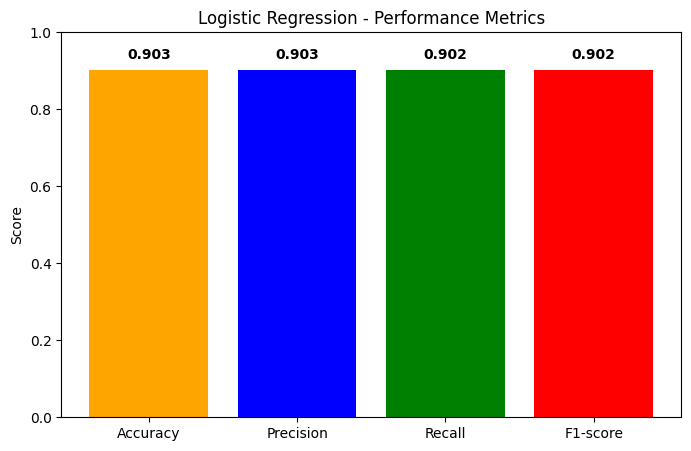


Logistic Regression Accuracy: 0.9029
              precision    recall  f1-score   support

           0     0.9020    0.8870    0.8945       301
           1     0.9037    0.9167    0.9101       348

    accuracy                         0.9029       649
   macro avg     0.9029    0.9019    0.9023       649
weighted avg     0.9029    0.9029    0.9029       649



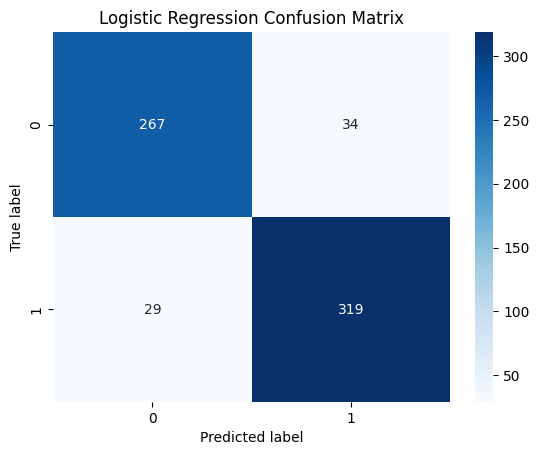

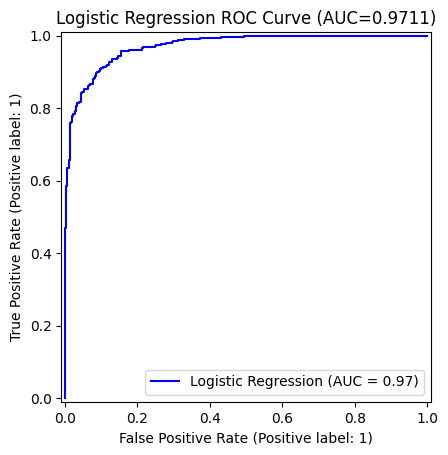

In [11]:
#Evaluate Logistic Regression with Feature importance report
evaluate_model(
    LogisticRegression(random_state=42),
    X, y, numeric_columns, categorical_columns,
    plot_color='blue',
    model_name='Logistic Regression'
)

##Logistic Regression Feature Importance

Source: https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html

<Figure size 1000x600 with 0 Axes>

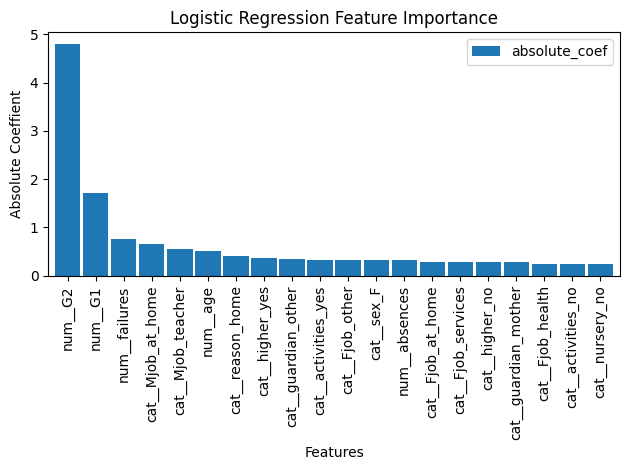

In [ ]:
#adding feature preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
])
X_transformed = preprocessor.fit_transform(X)
#print(X_transformed)
X_feature_names = preprocessor.get_feature_names_out()
# print(X_feature_names)
X_transformed_df=pd.DataFrame(X_transformed, columns=X_feature_names)
# print(X_transformed_df)

#logistic regression and coefficient
random_state=42
logistic_regression_model=LogisticRegression(random_state=random_state)
logistic_regression_model.fit(X_transformed_df, y)
log_regr_coef=logistic_regression_model.coef_[0]
feature_importance_log_regr=pd.DataFrame({
    'feature_names':X_feature_names,
    'absolute_coef':np.abs(log_regr_coef)
})
# print(feature_importance_log_regr)
sorted_feature_importance_log_regr= feature_importance_log_regr.sort_values(by='absolute_coef', ascending=False)[:20]

#plot feature importance-Logistic Regression
plt.figure(figsize=(10,6))
sorted_feature_importance_log_regr.plot(kind='bar', x ='feature_names', width=0.9)
plt.title('Logistic Regression Feature Importance')
plt.xlabel('Features')
plt.ylabel('Absolute Coeffient')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


###Hypothesis testing paired t-test (evaluate accuracy of Logistic Regression on G2 vs all features)

Hypothesis t-test to show that it is statistical significant to reject null hypothesis that accuracy using only G2 = accuracy using all features

H0: mean of accuracy using G2 only = mean of accuracy using all features

H1: mean of accuracy using G2 only != mean of accuracy using all features

Tutorial: https://www.datacamp.com/tutorial/an-introduction-to-python-t-tests

In [ ]:
#evaluate Logistic Regression model with G2
important_thresold=2
X_G2_df_lr=X_transformed_df[["num__G2"]]
#print(X_G2_df_lr)

num_folds=5
cv=StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state)

#accuracy score on G2 only
cv_score_lr_g2=cross_val_score(LogisticRegression(random_state=random_state), X_G2_df_lr, y, cv=cv)
print(f'Logistic Regression Accuracy on G2: {cv_score_lr_g2.mean():.4}')

#accuracy score on all features
cv_score_lr_all_features=cross_val_score(LogisticRegression(random_state=random_state), X_transformed_df,y, cv=cv)
print(f'Logistic Regression Accuracy on all features: {cv_score_lr_all_features.mean():.4}')

t_stat_lr_g2_all_features, p_value_lr_g2_all_features=stats.ttest_ind(cv_score_lr_g2, cv_score_lr_all_features)
print('t-test result(Logistic Regression on G2 vs all features)')
print(f't_stat_lr_g2_all_features {t_stat_lr_g2_all_features}')
print(f'p_value_lr_g2_all_features {p_value_lr_g2_all_features}')

Logistic Regression Accuracy on G2: 0.9383
Logistic Regression Accuracy on all features: 0.9029
t-test result(Logistic Regression on G2 vs all features)
t_stat_lr_g2_all_features 1.8428270581197819
p_value_lr_g2_all_features 0.10259957145392741


###Hypothesis Testing (McNemar Test) Compare Logistic Regression vs XGBoost
H0: Logistic Regression and XGBoost have the same performance

H1: Logistic Regression and XGBoost have different performance

Source: https://rasbt.github.io/mlxtend/user_guide/evaluate/mcnemar/

In [ ]:

num_folds=5
cv=StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state)
#Get Logistic Regression cv predictions

lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(random_state=random_state))
])
y_preds_lr=cross_val_predict(lr_pipe, X, y, cv=cv, method='predict')
#print(y_preds_lr)

#Get XGBoost cv predictions
xgboost_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(eval_metric='logloss', random_state=random_state ))
])

y_preds_xgb=cross_val_predict(xgboost_pipe, X, y, cv=cv, method='predict')
#print(y_preds_xgb)
# print(type(y))
# print(type(y_preds_lr))
# print(type(y_preds_xgb))

#convert y panda object to np.array
y_np = y.to_numpy()
# print(y_np)

#Build contigency table which counts the number of predictions where:
#a: LR and XGB are correct
#b: LR correct and XGB wrong
#c: LR wrong and XGB correct
#d: LR and XGB are wrong

a = np.sum((y_preds_lr == y_np) & (y_preds_xgb == y_np))
b = np.sum((y_preds_lr == y_np) & (y_preds_xgb != y_np))
c = np.sum((y_preds_lr != y_np) & (y_preds_xgb == y_np))
d = np.sum((y_preds_lr != y_np) & (y_preds_xgb != y_np))

print(a,b,c,d)

#contigency table
lr_xgb_table = [[a,b],
                [c,d]]
# print(table)

result = mcnemar(lr_xgb_table, exact=False, correction=True)
print('McNemar test Logistic Regression vs XGBoost')
print(f'McNemar chi-square: {result.statistic:.4f}')
print(f'p-value: {result.pvalue:.6f}')


580 6 22 41
McNemar test Logistic Regression vs XGBoost
McNemar chi-square: 8.0357
p-value: 0.004586


#Decision Tree

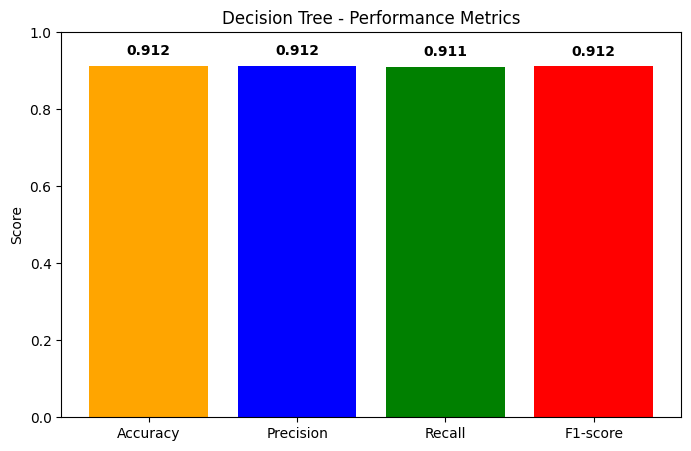


Decision Tree Accuracy: 0.9122
              precision    recall  f1-score   support

           0     0.9150    0.8937    0.9042       301
           1     0.9099    0.9282    0.9189       348

    accuracy                         0.9122       649
   macro avg     0.9124    0.9109    0.9116       649
weighted avg     0.9122    0.9122    0.9121       649



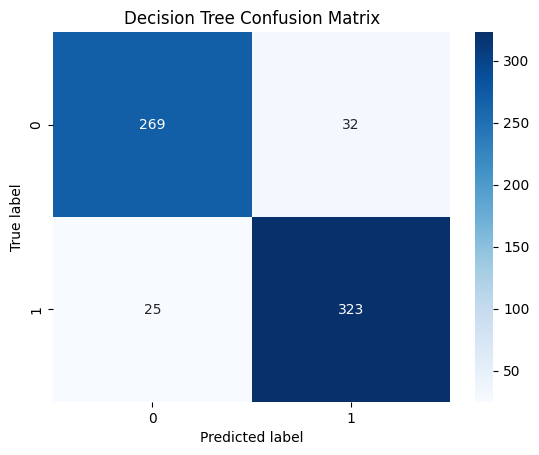

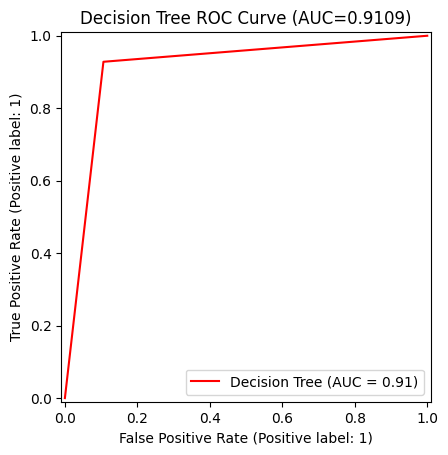

In [ ]:
#Evaluate model and feature importance report
evaluate_model(
    DecisionTreeClassifier(random_state=42),
    X, y, numeric_columns, categorical_columns,
    plot_color='red',
    model_name='Decision Tree'
)


##Decision Tree (Feature Importance)
Source: https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html

<Figure size 1000x600 with 0 Axes>

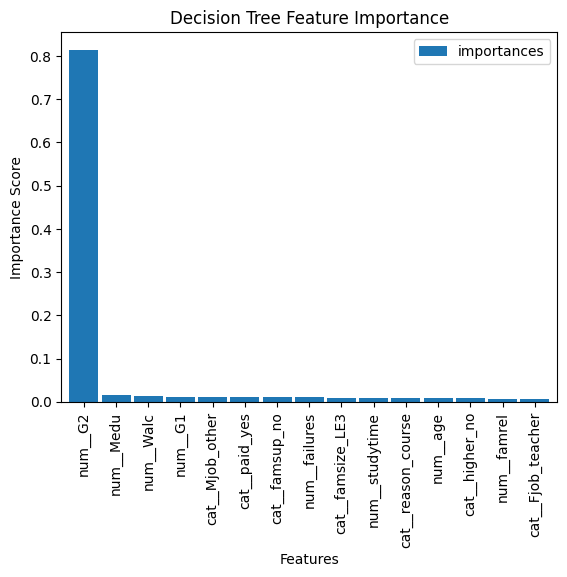

In [ ]:
#Feature Importance
decision_tree_model=DecisionTreeClassifier(random_state=random_state)
decision_tree_model.fit(X_transformed_df, y)
importances=decision_tree_model.feature_importances_
#print(importances)

df_decision_tree_feature_importance = pd.DataFrame({
    'feature_names': X_feature_names,
    'importances': importances
})

df_sorted_decision_tree_feature_importance=df_decision_tree_feature_importance.sort_values(by='importances', ascending=False)[:15]
plt.figure(figsize=(10,6))
df_sorted_decision_tree_feature_importance.plot(kind='bar', x='feature_names', width=0.9)
plt.title('Decision Tree Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()



###Hypothesis testing: paired t-test (Decision Tree with only G2 vs all features)

Hypothesis t-test to show that it is statistical significant to reject null hypothesis that accuracy using only G2 = accuracy using all features

H0: mean of accuracy using G2 only = mean of accuracy using all features

H1: mean of accuracy using G2 only != mean of accuracy using all features

Tutorial: https://www.datacamp.com/tutorial/an-introduction-to-python-t-tests

In [ ]:
#we use feature that has importance point > 0.5. in this case which is G2
num_folds=5
important_thresold = 0.5
important_features = X_feature_names[importances>important_thresold]
X_G2_df = X_transformed_df[important_features]
#print(important_features)
#print(X_G2_df)

cv_score_dt_g2=cross_val_score(DecisionTreeClassifier(random_state=random_state), X_G2_df,y,cv=cv)
mean_score_dt_g2=cv_score_dt_g2.mean()
print(f'Decision Tree Accuracy only G2: {cv_score_dt_g2.mean():.4}')
cv_score_dt_all_features=cross_val_score(DecisionTreeClassifier(random_state=random_state), X_transformed_df, y, cv=cv)
print(f'Decision Tree Accuracy all features: {cv_score_dt_all_features.mean():.4}')

t_stat_dt_g2_all_features, p_value_dt_g2_all_features=stats.ttest_ind(cv_score_dt_g2, cv_score_dt_all_features)
print('t-test result (Decision Tree Accuracy on G2 vs all features):')
print(f't_statg2_all_features: {t_stat_dt_g2_all_features:.4}')
print(f'p_value_g2_all_features: {p_value_dt_g2_all_features:.4}')

Decision Tree Accuracy only G2: 0.9383
Decision Tree Accuracy all features: 0.9106
t-test result (Decision Tree Accuracy on G2 vs all features):
t_statg2_all_features: 1.86
p_value_g2_all_features: 0.09987


#Hypothesis testing: (McNemar Test) Decision Tree vs XGBoost

H0: Decision Tree and XGBoost have the same performance

H1: Decision Tree and XGBoost have different performance


Source: https://rasbt.github.io/mlxtend/user_guide/evaluate/mcnemar/

In [ ]:
#Get CV predictions

dt_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=random_state))
])
y_preds_dt=cross_val_predict(dt_pipe, X, y, cv = cv, method='predict')
# print(y_preds_dt)
xgboost_pipe=Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(eval_metric='logloss', random_state=random_state))
])
y_preds_xgb=cross_val_predict(xgboost_pipe, X, y, cv=cv, method='predict')
#print(y_preds_xgb)

#Convert type of y (panda to np.array)
y_np = y.to_numpy()

#Create contigency table of predictions where:
#a: Decision Tree and XGBoost are correct
#b: Decision Tree correct and XGBoost wrong
#c: Decision Tree wrong and XGBoost correct
#d: Decision Tree and XGBOost are wrong

a=np.sum((y_preds_dt == y_np) & (y_preds_xgb == y_np))
b=np.sum((y_preds_dt == y_np) & (y_preds_xgb != y_np))
c=np.sum((y_preds_dt != y_np) & (y_preds_xgb == y_np))
d=np.sum((y_preds_dt != y_np) & (y_preds_xgb != y_np))

dt_xgb_table = [[a,b],
                [c,d]]
print(a,b,c,d)
# print(dt_xgb_table)

result=mcnemar(dt_xgb_table, exact=False, correction=True)
print('McNemar test Decision Tree vs XGBoost')
print('chi-square:', result.statistic)
print('p-value:', result.pvalue)



579 13 23 34
McNemar test Decision Tree vs XGBoost
chi-square: 2.25
p-value: 0.13361440253771584


# Gaussian Naive Bayes

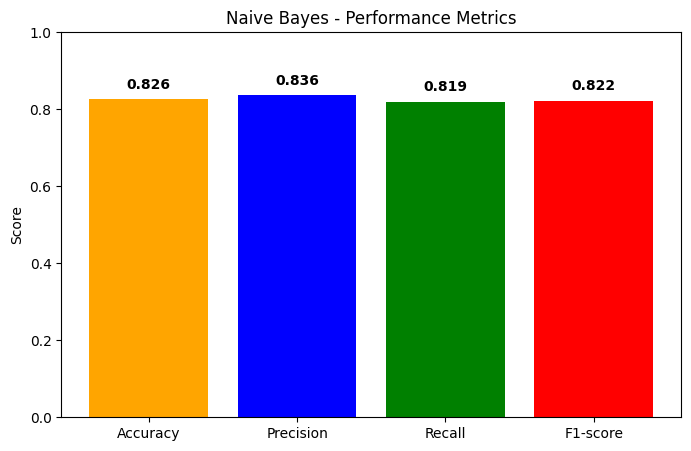


Naive Bayes Accuracy: 0.8259
              precision    recall  f1-score   support

           0     0.8790    0.7243    0.7942       301
           1     0.7930    0.9138    0.8491       348

    accuracy                         0.8259       649
   macro avg     0.8360    0.8190    0.8217       649
weighted avg     0.8329    0.8259    0.8236       649



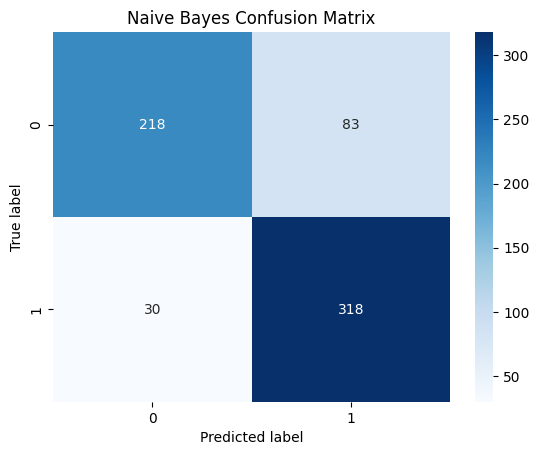

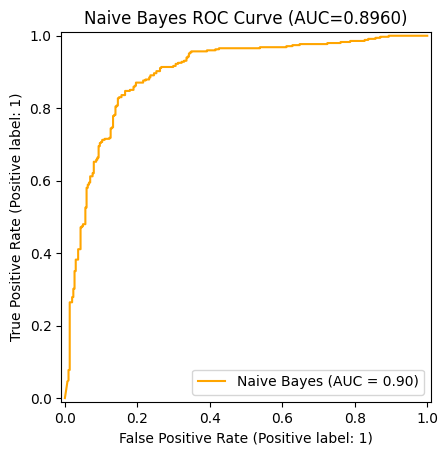

In [ ]:
evaluate_model(
    GaussianNB(),
    X, y, numeric_columns, categorical_columns,
    plot_color='orange',
    model_name='Naive Bayes'
)


## Feature Importance - Naive Bayes

### Permutation Importance

In [ ]:
preprocess = ColumnTransformer([
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
])

pipe = Pipeline([
    ('preprocess', preprocess),
    ('clf', GaussianNB())
])

pipe.fit(X, y)

# Get both full feature names, numeric + one-hot
feat_names = (
    numeric_columns +
    list(pipe.named_steps['preprocess']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_columns))
)


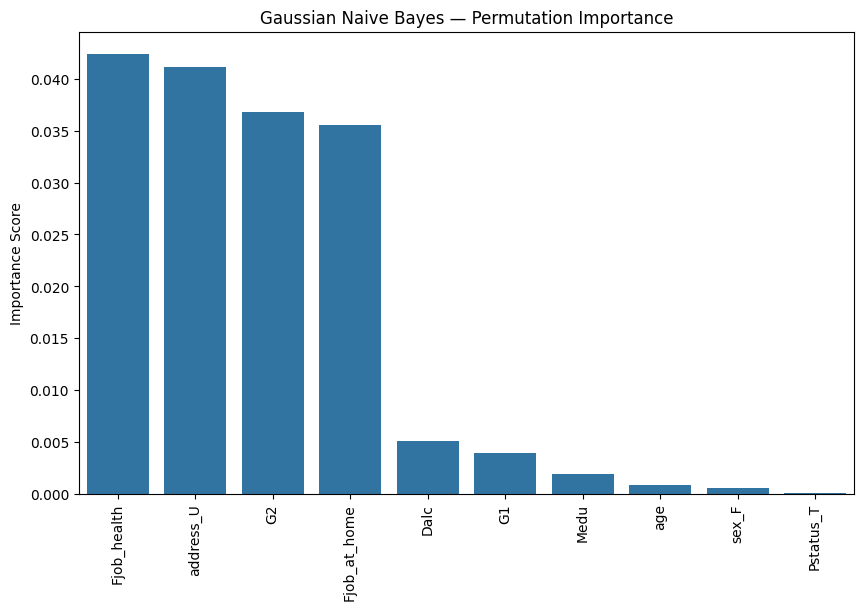

In [ ]:
r = permutation_importance(pipe, X, y, n_repeats=20, random_state=42)
perm_importances = r.importances_mean
sorted_idx = perm_importances.argsort()[::-1]

plt.figure(figsize=(10,6))
sns.barplot(
    x=np.array(feat_names)[sorted_idx][:10],
    y=perm_importances[sorted_idx][:10]
)
plt.xticks(rotation=90)
plt.title("Gaussian Naive Bayes — Permutation Importance")
plt.ylabel("Importance Score")
plt.show()


### Using Naive Bayes parameters
Theta/Sigma Importance

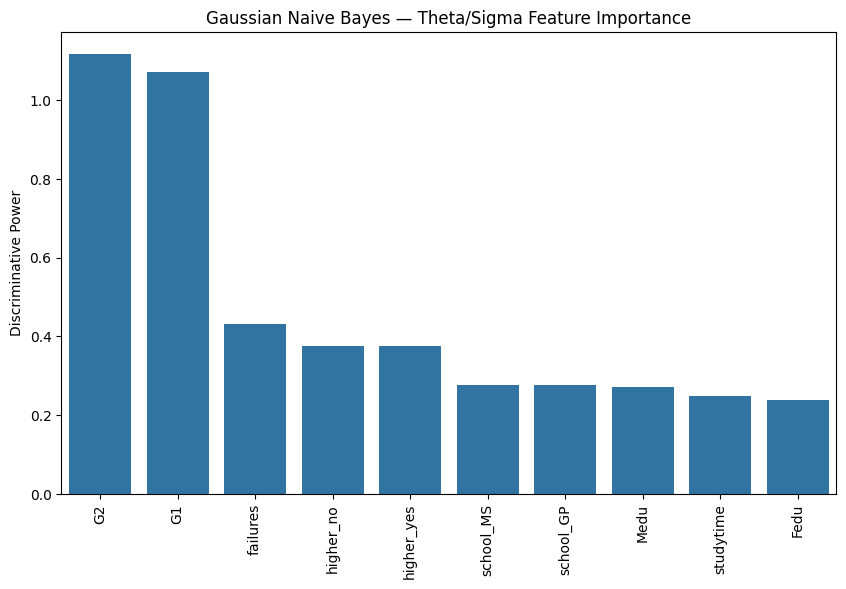

In [ ]:
nb = pipe.named_steps['clf']

means = nb.theta_
vars = nb.var_

theta_importance = np.abs(means[1] - means[0]) / (
    np.sqrt(vars[0]) + np.sqrt(vars[1])
)

sorted_idx2 = theta_importance.argsort()[::-1]

plt.figure(figsize=(10,6))
sns.barplot(
    x=np.array(feat_names)[sorted_idx2][:10],
    y=theta_importance[sorted_idx2][:10]
)
plt.xticks(rotation=90)
plt.title("Gaussian Naive Bayes — Theta/Sigma Feature Importance")
plt.ylabel("Discriminative Power")
plt.show()

## Hypothesis Testing

### Feature-level t-tests

In [ ]:
# Low p-value (< .05) → feature significantly separates classes
# High p-value → weak evidence of separation
feature_results = []

for col in numeric_columns:
    class0 = X[y == 0][col]
    class1 = X[y == 1][col]
    stat, p = ttest_ind(class0, class1, equal_var=False)
    feature_results.append({"feature": col, "p_value": p})

pd.DataFrame(results).sort_values("p_value")

,feature,p_value
14,G2,5.924742e-114
13,G1,2.548308e-109
5,failures,1.067822e-17
1,Medu,1.282728e-11
4,studytime,5.771843e-10
2,Fedu,2.056157e-09
9,Dalc,2.469255e-07
3,traveltime,2.948321e-06
10,Walc,1.696951e-05
12,absences,4.649111e-05


### McNemar’s test

In [ ]:
nb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clf',  GaussianNB())
])
y_preds_nb=cross_val_predict(nb_pipe, X, y, cv = cv, method='predict')

xgboost_pipe=Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(eval_metric='logloss', random_state=random_state))
])
y_preds_xgb=cross_val_predict(xgboost_pipe, X, y, cv=cv, method='predict')

#Convert type of y (panda to np.array)
y_np = y.to_numpy()

#Create contigency table of predictions where:
#a: GaussianNB and XGBoost are correct
#b: GaussianNB correct and XGBoost wrong
#c: GaussianNB wrong and XGBoost correct
#d: GaussianNB and XGBoost are wrong

a=np.sum((y_preds_nb == y_np) & (y_preds_xgb == y_np))
b=np.sum((y_preds_nb == y_np) & (y_preds_xgb != y_np))
c=np.sum((y_preds_nb != y_np) & (y_preds_xgb == y_np))
d=np.sum((y_preds_nb != y_np) & (y_preds_xgb != y_np))

nb_xgb_table = [[0,b],
                [c,0]]
print(a,b,c,d)

result=mcnemar(nb_xgb_table, exact=False, correction=True)
print('McNemar test Gaussian Naive Bayes vs XGBoost')
print('chi-square:', result.statistic)
print('p-value:', result.pvalue)


512 24 90 23
McNemar test Gaussian Naive Bayes vs XGBoost
chi-square: 37.06140350877193
p-value: 1.1446718539887972e-09


# Random Forest

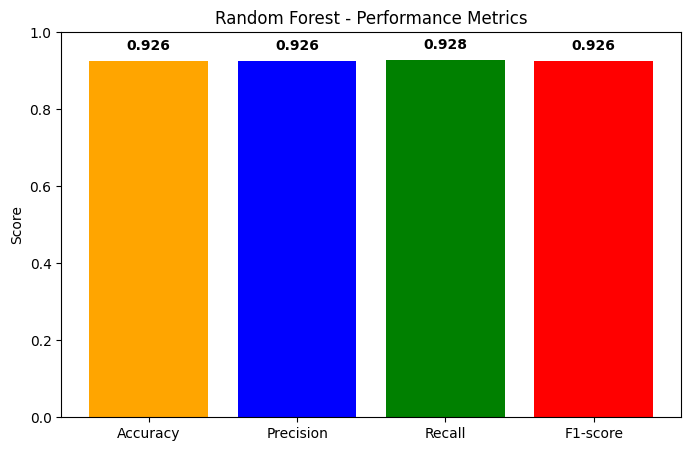


Random Forest Accuracy: 0.9260
              precision    recall  f1-score   support

           0     0.8892    0.9601    0.9233       301
           1     0.9630    0.8966    0.9286       348

    accuracy                         0.9260       649
   macro avg     0.9261    0.9283    0.9259       649
weighted avg     0.9288    0.9260    0.9261       649



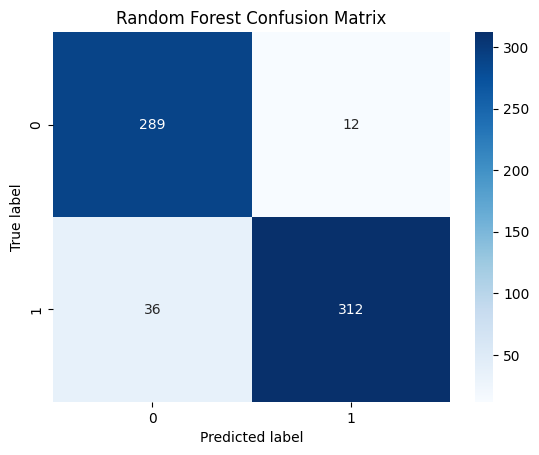

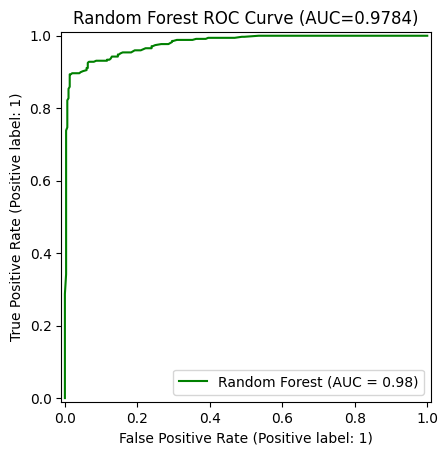

In [ ]:
evaluate_model(
    RandomForestClassifier(n_estimators=200, random_state=42),
    X, y, numeric_columns, categorical_columns,
    plot_color='green',
    model_name='Random Forest'
)


## Feature Importance

In [ ]:
preprocess = ColumnTransformer([
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
])

pipe = Pipeline([
    ('preprocess', preprocess),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

pipe.fit(X, y)

feat_names = (
    numeric_columns +
    list(pipe.named_steps['preprocess']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_columns))
)

### Permutation Importance

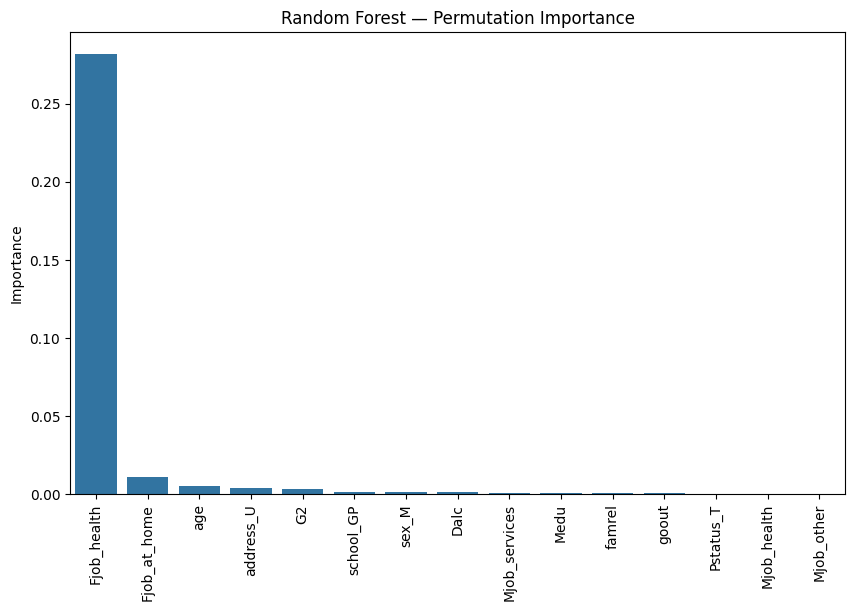

In [ ]:
r = permutation_importance(pipe, X, y, n_repeats=15, random_state=42)
perm_importance = r.importances_mean
sorted_idx = perm_importance.argsort()[::-1]

plt.figure(figsize=(10,6))
sns.barplot(
    x=np.array(feat_names)[sorted_idx][:15],
    y=perm_importance[sorted_idx][:15]
)
plt.xticks(rotation=90)
plt.title("Random Forest — Permutation Importance")
plt.ylabel("Importance")
plt.show()

### Native Gini Importance

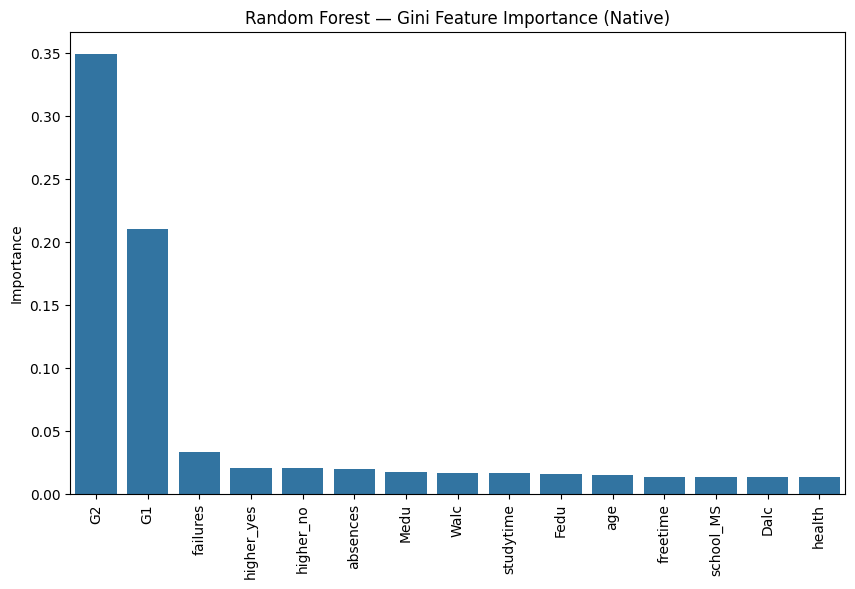

In [ ]:
rf = pipe.named_steps['clf']
gini_importance = rf.feature_importances_

sorted_idx2 = gini_importance.argsort()[::-1]

plt.figure(figsize=(10,6))
sns.barplot(
    x=np.array(feat_names)[sorted_idx2][:15],
    y=gini_importance[sorted_idx2][:15]
)
plt.xticks(rotation=90)
plt.title("Random Forest — Gini Feature Importance (Native)")
plt.ylabel("Importance")
plt.show()


## Hypothesis testing

RF is non-parametric, so the typical hypothesis testing does not apply. However, hypothesis testing can be done on the model's behavior instead

### McNemar's Test

In [ ]:
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clf',  RandomForestClassifier())
])
y_preds_rf=cross_val_predict(rf_pipe, X, y, cv = cv, method='predict')

xgboost_pipe=Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(eval_metric='logloss', random_state=random_state))
])
y_preds_xgb=cross_val_predict(xgboost_pipe, X, y, cv=cv, method='predict')

#Convert type of y (panda to np.array)
y_np = y.to_numpy()

#Create contigency table of predictions where:
#a: Random Forest and XGBoost are correct
#b: Random Forest correct and XGBoost wrong
#c: Random Forest wrong and XGBoost correct
#d: Random Forest and XGBoost are wrong

a=np.sum((y_preds_rf == y_np) & (y_preds_xgb == y_np))
b=np.sum((y_preds_rf == y_np) & (y_preds_xgb != y_np))
c=np.sum((y_preds_rf != y_np) & (y_preds_xgb == y_np))
d=np.sum((y_preds_rf != y_np) & (y_preds_xgb != y_np))

rf_xgb_table = [[0,b],
                [c,0]]
print(a,b,c,d)

result=mcnemar(rf_xgb_table, exact=False, correction=True)
print('McNemar test Random Forest vs XGBoost')
print('chi-square:', result.statistic)
print('p-value:', result.pvalue)

594 13 8 34
McNemar test Random Forest vs XGBoost
chi-square: 0.7619047619047619
p-value: 0.38273308888522595


In [ ]:
rf_pipe = Pipeline([
    ('preprocess', ColumnTransformer([
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_preds = cross_val_predict(rf_pipe, X, y, cv=5)


In [ ]:
majority_class = y.value_counts().idxmax()
baseline_preds = np.full_like(y, fill_value=majority_class)


In [ ]:
from statsmodels.stats.contingency_tables import mcnemar

# b = RF wrong, Baseline correct
# c = RF correct, Baseline wrong
b = np.sum((rf_preds != y) & (baseline_preds == y))
c = np.sum((rf_preds == y) & (baseline_preds != y))

# Contingency table required by McNemar test
table = [[0, b],
         [c, 0]]

result = mcnemar(table, exact=False, correction=True)

print("McNemar’s statistic:", result.statistic)
print("p-value:", result.pvalue)


McNemar’s statistic: 186.15705128205127
p-value: 2.193854545601905e-42


# SVM

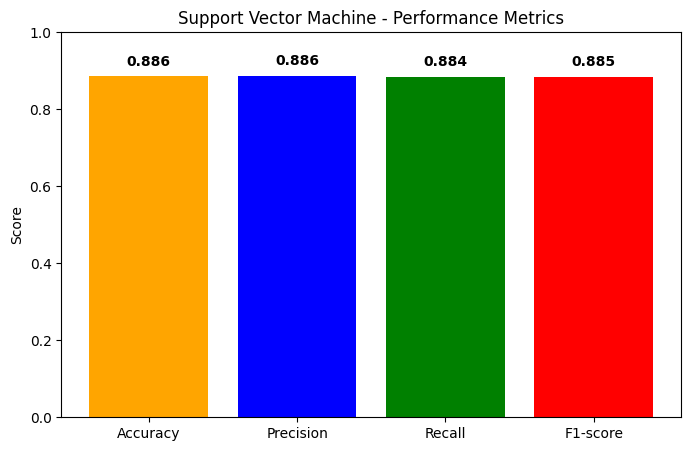


Support Vector Machine Accuracy: 0.8860
              precision    recall  f1-score   support

           0     0.8900    0.8605    0.8750       301
           1     0.8827    0.9080    0.8952       348

    accuracy                         0.8860       649
   macro avg     0.8864    0.8843    0.8851       649
weighted avg     0.8861    0.8860    0.8858       649



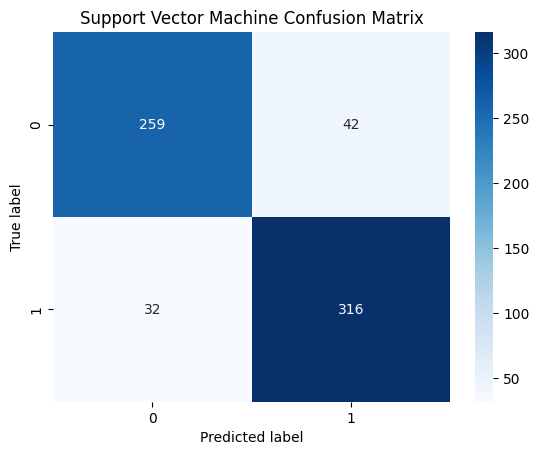

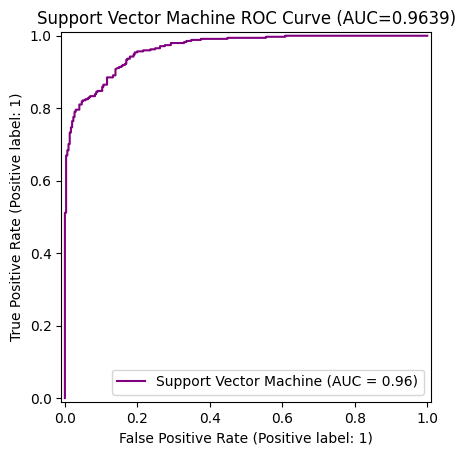

In [ ]:
evaluate_model(
    SVC(kernel='rbf', probability=True, random_state=42),
    X, y, numeric_columns, categorical_columns,
    plot_color='purple',
    model_name='Support Vector Machine'
)


In [ ]:
def plot_permutation_importance(
    model, X, y, numeric_columns, categorical_columns,
    model_name="Model", n_repeats=30
):
    """
    Compute and plot permutation importance for any model (SVM, XGBoost, etc.)
    using the SAME preprocessing as in evaluate_model.
    """
    # Build the same preprocess + model pipeline
    preprocess = ColumnTransformer([
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])
    pipe = Pipeline([
        ('preprocess', preprocess),
        ('clf', model)
    ])

    # Fit on full data
    pipe.fit(X, y)

    # Permutation importance on the original features
    result = permutation_importance(
        pipe, X, y,
        n_repeats=n_repeats,
        random_state=42,
        n_jobs=-1
    )

    importances = result.importances_mean
    std = result.importances_std

    feat_names = X.columns.to_numpy()
    idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(f"Permutation Importance ({model_name})")
    plt.bar(range(len(feat_names)), importances[idx])
    plt.xticks(range(len(feat_names)), feat_names[idx], rotation=90)
    plt.ylabel("Mean decrease in score")
    plt.xlabel("Feature")
    plt.tight_layout()
    plt.show()


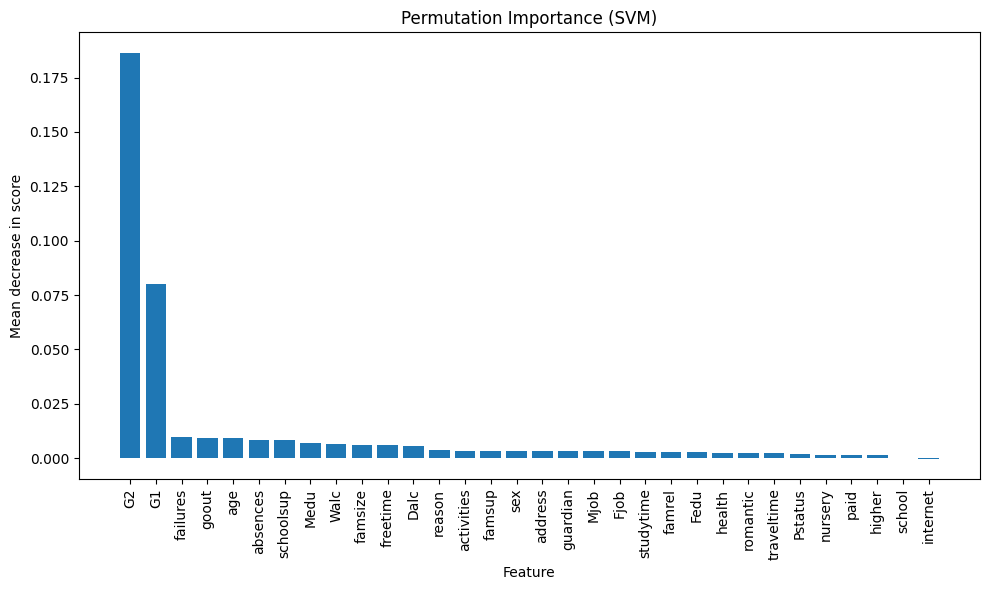

In [ ]:
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

plot_permutation_importance(
    svm_model,
    X, y,
    numeric_columns, categorical_columns,
    model_name="SVM"
)

#XGBOOST

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:12:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:12:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:12:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:12:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:12:15] WARNING: /w

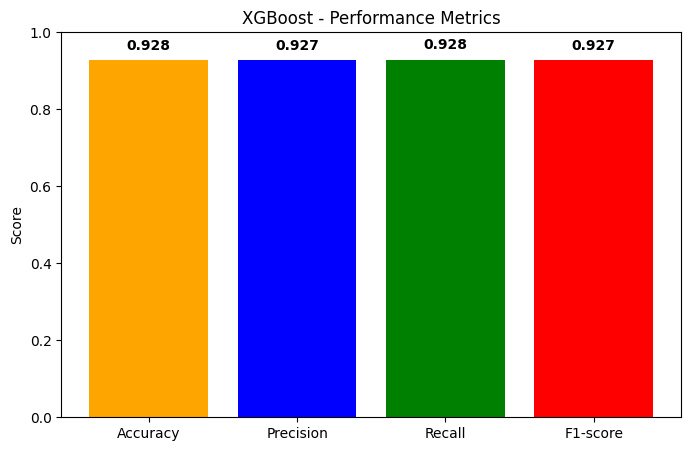


XGBoost Accuracy: 0.9276
              precision    recall  f1-score   support

           0     0.9123    0.9336    0.9228       301
           1     0.9413    0.9224    0.9318       348

    accuracy                         0.9276       649
   macro avg     0.9268    0.9280    0.9273       649
weighted avg     0.9279    0.9276    0.9276       649



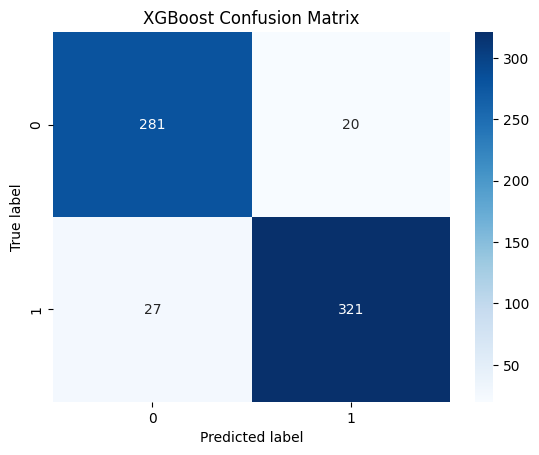

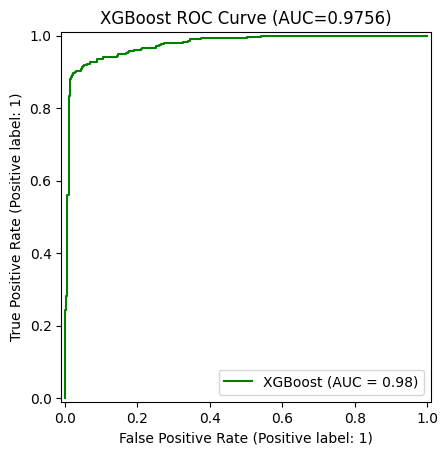

In [ ]:
from xgboost import XGBClassifier

ensemble_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

evaluate_model(
    ensemble_xgb,
    X, y, numeric_columns, categorical_columns,
    plot_color='green',
    model_name='XGBoost'
)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:12:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


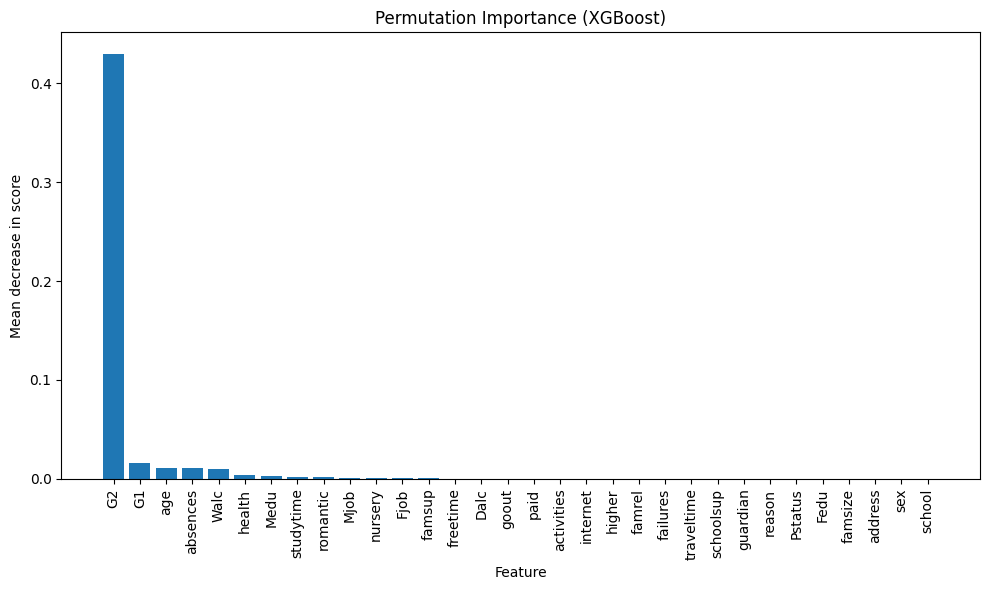

In [ ]:

plot_permutation_importance(
    ensemble_xgb,
    X, y,
    numeric_columns, categorical_columns,
    model_name="XGBoost"
)



# Ensemble - LR, NB, SVM, RF, DT

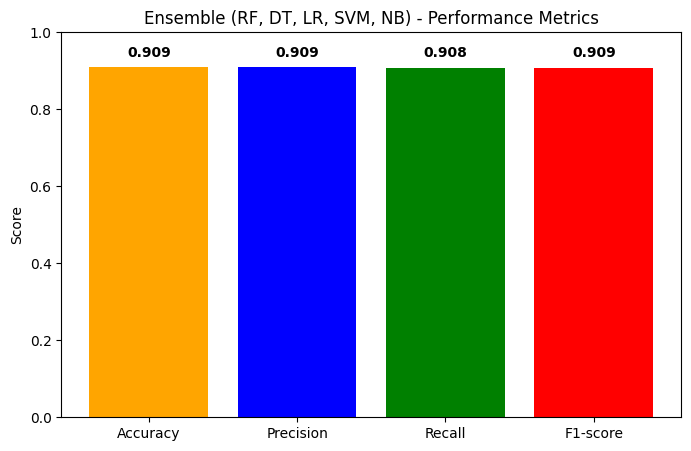


Ensemble (RF, DT, LR, SVM, NB) Accuracy: 0.9091
              precision    recall  f1-score   support

           0     0.9088    0.8937    0.9012       301
           1     0.9093    0.9224    0.9158       348

    accuracy                         0.9091       649
   macro avg     0.9091    0.9081    0.9085       649
weighted avg     0.9091    0.9091    0.9090       649



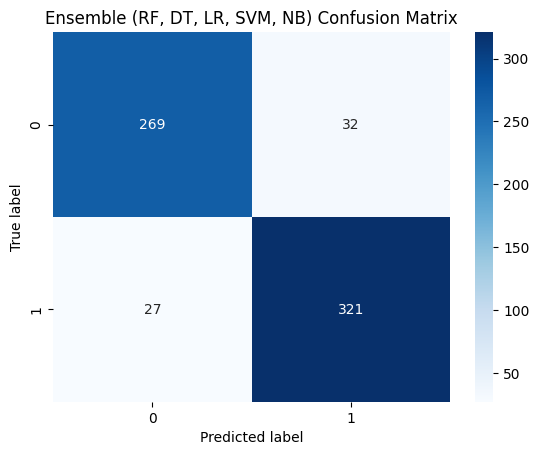

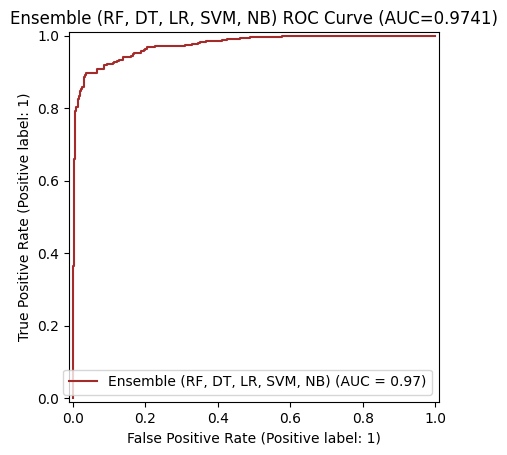

In [ ]:
ensemble_custom = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
        ('dt', DecisionTreeClassifier(random_state=42)),
        ('lr', LogisticRegression(max_iter=2000, solver='liblinear')),
        ('svm', SVC(kernel='rbf', probability=True, random_state=42)),
        ('nb', GaussianNB())
    ],
    voting='soft'  # 'soft' uses predicted probabilities for averaging
)

# Evaluate the custom ensemble
evaluate_model(
    ensemble_custom,
    X, y, numeric_columns, categorical_columns,
    plot_color='brown',
    model_name='Ensemble (RF, DT, LR, SVM, NB)'
)

#McNemar's Test (SVM vs XGBoost)

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar


preprocess = ColumnTransformer([
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# considering CV predictions ONLY (no accuracy, no plots)
svm_pipe = Pipeline([('preprocess', preprocess),
                     ('clf', SVC(kernel='rbf', probability=True, random_state=42))])

xgb_pipe = Pipeline([('preprocess', preprocess),
                     ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))])

y_pred_svm = cross_val_predict(svm_pipe, X, y, cv=cv, method='predict')
y_pred_xgb = cross_val_predict(xgb_pipe, X, y, cv=cv, method='predict')

# Building McNemar contingency table
b = np.sum((y_pred_svm == y) & (y_pred_xgb != y))   # SVM correct, XGB wrong
c = np.sum((y_pred_svm != y) & (y_pred_xgb == y))   # SVM wrong, XGB correct

table = [[0, b],
         [c, 0]]

result = mcnemar(table, exact=False, correction=True)

print(" McNemar's Test (SVM vs XGBoost) ")
print(f"b = {b} (SVM correct, XGB wrong)")
print(f"c = {c} (SVM wrong, XGB correct)")
print(f"Chi-square = {result.statistic:.4f}")
print(f"p-value    = {result.pvalue:.6f}")

if result.pvalue < 0.05:
    if c > b:
        print("XGBoost is statistically better than SVM.")
    else:
        print("SVM is statistically better than XGBoost.")



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:12:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:12:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:12:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:12:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 McNemar's Test (SVM vs XGBoost) 
b = 11 (SVM correct, XGB wrong)
c = 38 (SVM wrong, XGB correct)
Chi-square = 13.7959
p-value    = 0.000204
XGBoost is statistically better than SVM.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:12:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
